In [1]:
# Copyright IonQ Inc., all rights reserved

import numpy as np
import pandas as pd
import collections
import math
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import FixedLocator
from matplotlib.patches import Rectangle, Circle, RegularPolygon, Patch
from matplotlib.legend_handler import HandlerPatch
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

%matplotlib inline

In [2]:
alldata = pd.read_json('../results/data_AQcircuits.json')

In [3]:
nqubits_to_marginalize = {"ae": 2, "mc": -2 }

def merge_prob_dicts(dicts):
    ret = collections.defaultdict(lambda: 0)
    for d in dicts:
        for k, v in d.items():
            ret[k] += v
    total = sum(ret.values())
    return {k: v/total for k,v in ret.items()}

def marginalize(probs, nqubits_to_marginalize, nqubits):
    # negative nqubits_to_marginalize marginalizes initial qubits, positive marginalizes final
    if nqubits_to_marginalize == 0:
        return probs
    
    ret = collections.defaultdict(lambda: 0.0)

    for k, p in probs.items():
        if nqubits_to_marginalize < 0:
            k_marginalized = str(int(k) >> -nqubits_to_marginalize)
        else:
            mask = 2**(nqubits - nqubits_to_marginalize) - 1
            k_marginalized = str(int(k) & mask)
        ret[k_marginalized] += p
    return dict(ret)

def hellinger_fidelity(p, q):
    """p: result distribution, may be passed as a counts distribution
        q: the expected distribution to be compared against

    References:
        `Hellinger Distance @ wikipedia <https://en.wikipedia.org/wiki/Hellinger_distance>`_
        Qiskit Hellinger Fidelity Function
    """
    p_sum = sum(p.values())
    q_sum = sum(q.values())

    p_normed = {}
    for key, val in p.items():
        p_normed[key] = val / p_sum

    q_normed = {}
    for key, val in q.items():
        q_normed[key] = val / q_sum

    total = 0
    for key, val in p_normed.items():
        if key in q_normed.keys():
            total += (np.sqrt(val) - np.sqrt(q_normed[key])) ** 2
            del q_normed[key]
        else:
            total += val
    total += sum(q_normed.values())
    dist = np.sqrt(total) / np.sqrt(2)
    fidelity = (1 - dist**2) ** 2
    return fidelity

In [4]:
#Colorbar / colormap info used in several plots below
vmin = 2
vmax = 11
scale_f = lambda z: scale((np.log2(z)), vmin=vmin, vmax=vmax)
cmin = 2**vmin
cmax = 2**vmax
cmap = plt.cm.coolwarm

## Plots of data before error mitigation

In [5]:
# Compute dataframe of non-error-mitigated infidelities
out_rows = []
for _, row in alldata.iterrows():
    
    circuit_type = row['circuit_type']  
    ideal_probs = row['ideal_probabilities']
        
    #Fidelities of aggregated-over-variants histogram
    nq_to_marg = nqubits_to_marginalize.get(circuit_type, 0)
    ideal_probs = marginalize(ideal_probs, nq_to_marg, row['circuit_width'])
    merged_obs = merge_prob_dicts(row['measured_variant_probabilities'])
    merged_sim = merge_prob_dicts(row['simulated_variant_probabilities'])
    merged_obs = marginalize(merged_obs, nq_to_marg, row['circuit_width'])
    merged_sim = marginalize(merged_sim, nq_to_marg, row['circuit_width'])

    out_rows.append({'circuit_type': circuit_type,
                     'observed_Fc': hellinger_fidelity(merged_obs, ideal_probs),
                     'predicted_Fc': hellinger_fidelity(merged_sim, ideal_probs),
                     'circuit_width': row['circuit_width'],
                     'num_2q_gates': row['num_2q_gates'],
                     'postcompiled_num_2q_gates': row['postcompiled_num_2q_gates'],
                     'postcompiled_num_1q_gates': row['postcompiled_num_1q_gates']
                    })
df_fidelities = pd.DataFrame(out_rows)

Qubit range:  4 30
Size range:  13.0 169.31676725154983


/var/folders/t5/yw0j7tgx4kg2rv2r_50yn8cc0000gq/T/ipykernel_89757/971955321.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


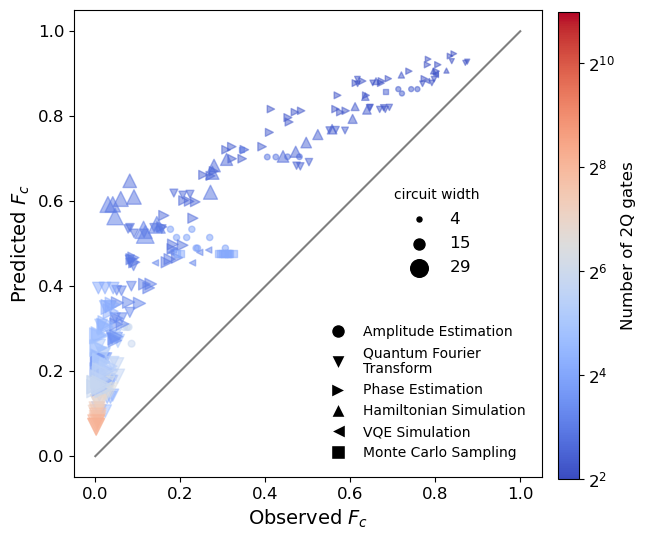

In [6]:
# Unmitigated Observed_Fc vs Predicted_Fc

algorithm_names_and_symbols = [
        ("ae",   "Amplitude Estimation", 'o'),
        ("qft",  "Quantum Fourier\nTransform", 'v'),
        ("pe",   "Phase Estimation", '>'),
        ("hsim", "Hamiltonian Simulation", '^'),
        ("vqe",  "VQE Simulation", '<'),
        ("mc",   "Monte Carlo Sampling", 's')  
    ]

fig, ax = plt.subplots(figsize=(7,5.5))

xs = np.linspace(0, 1, 100)
plt.plot(xs, xs, label=None, color='gray')

all_sizes = []
all_nqubits = []
    
for circuit_type, app_name, marker in algorithm_names_and_symbols:
    df_for_app = df_fidelities[df_fidelities['circuit_type'] == circuit_type] 
    nqubits_for_app = df_for_app['circuit_width']    
    sizes = np.array(nqubits_for_app)**1.5 + 5
    all_sizes.extend(sizes)
    all_nqubits.extend(nqubits_for_app)
    sc = plt.scatter(df_for_app['observed_Fc'], df_for_app['predicted_Fc'],
                     s=sizes, c=df_for_app['num_2q_gates'], cmap=cmap,
                     label=app_name, alpha=0.5, marker=marker, vmin=cmin, vmax=cmax)

ax.set_aspect('equal')
plt.tick_params(axis='both', labelsize=12)
plt.xlabel("Observed $F_c$", fontsize=14)
plt.ylabel("Predicted $F_c$", fontsize=14)

legend_elements = []
for circuit_type, app_name, marker in algorithm_names_and_symbols:
    legend_elements.append(Line2D([0], [0], marker=marker, color='w', label=app_name,
                           markerfacecolor='k', markersize=10))
legend1 = plt.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.75, 0.01), frameon=False)
ax.add_artist(legend1)

qmin, qmax = min(all_nqubits), max(all_nqubits)
smin, smax = min(all_sizes), max(all_sizes)
print("Qubit range: ",qmin, qmax)
print("Size range: ",smin, smax)

legend_nqubits = np.array([4, 15, 29])
legend_sizes = legend_nqubits**1.5 + 5
dummy_plots = [plt.scatter([],[], s=msize, color='k') for msize in legend_sizes]
leg = plt.legend([p for p in dummy_plots], [f"${nq}$" for nq in legend_nqubits], ncol=1, fontsize=12,
                loc = 'lower right', title='circuit width', scatterpoints = 1, frameon=False,
                bbox_to_anchor=(0.9, 0.4))  # size legend

#fig.subplots_adjust(right=0.85)
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
#norm = mpl.colors.LogNorm(vmin=cmin, vmax=cmax)
ax_cb = fig.add_axes([.86, 0.12, 0.03, 0.85]);
cb = mpl.colorbar.ColorbarBase(ax_cb, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
cb.set_label('Number of 2Q gates', fontsize=12)
ax_cb.tick_params(labelsize=12)

cbticks = [2,4,6,8,10]
cb.set_ticks(cbticks)
cb.set_ticklabels(['$2^{%d}$'%x for x in cbticks])

fig.tight_layout()
plt.savefig("fig_noem_predicted_vs_observed.pdf", format="pdf", bbox_inches = 'tight')

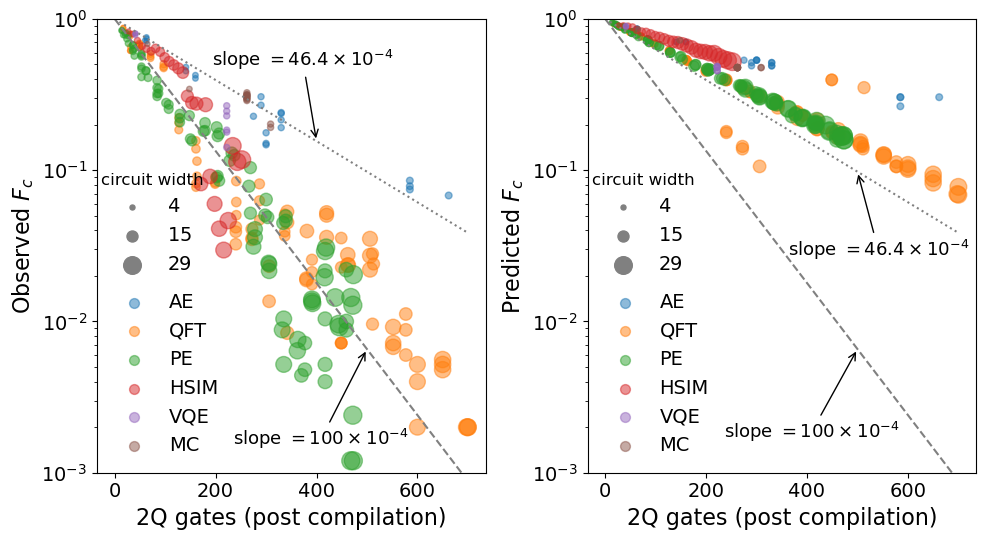

In [7]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5.5))

def create_Fcvs2Qcount_plot(ax, eps2q_line_vals, ylabel, ycolumn, show_legends=True, title=None, long_names=False):
    xs = np.linspace(0,700,100)
    for eps2q, ls in zip(eps2q_line_vals, [':', '--', '-']):
        ax.plot(xs, (1.0 - eps2q)**xs, label=None, color='gray', ls=ls)

    all_sizes = []
    all_nqubits = []

    for circuit_type, app_name, marker in algorithm_names_and_symbols:
        df_for_app = df_fidelities[df_fidelities['circuit_type'] == circuit_type] 
        nqubits_for_app = df_for_app['circuit_width']    
        sizes = np.array(nqubits_for_app)**1.5 + 5
        all_sizes.extend(sizes)
        all_nqubits.extend(nqubits_for_app)
        lbl = app_name if long_names else circuit_type.upper()
        sc = ax.scatter(df_for_app['postcompiled_num_2q_gates'], df_for_app[ycolumn],
                         s=sizes, label=lbl, alpha=0.5) #, marker=marker)
    ax.set_xlabel('2Q gates (post compilation)', fontsize=16)
    ax.set_ylabel(ylabel, fontsize=16)
    ax.tick_params(axis='both', labelsize=14)
    ax.set_yscale('log')
    ax.set_ylim(1e-3, 1)
    
    if title:
        ax.set_title(title)

    if show_legends:
        legend1 = ax.legend(fontsize=14, frameon=False)
        for handle in legend1.legend_handles:
            handle.set_sizes([50.0])
        ax.add_artist(legend1)

        #Circuit width legend
        legend_nqubits = np.array([4, 15, 29])
        legend_sizes = legend_nqubits**1.5 + 5
        dummy_plots = [ax.scatter([],[], s=msize, color='gray') for msize in legend_sizes]
        leg = ax.legend([p for p in dummy_plots], [f"${nq}$" for nq in legend_nqubits], ncol=1, fontsize=14,
                        loc = 'lower right', title='circuit width', scatterpoints = 1, frameon=False,
                        bbox_to_anchor=(0.32, 0.4))  # size legend
        plt.setp(leg.get_title(),fontsize=12)


create_Fcvs2Qcount_plot(axs[0], [0.00464, 0.01], 'Observed $F_c$', 'observed_Fc') #, title="Measurement")
create_Fcvs2Qcount_plot(axs[1], [0.00464, 0.01], 'Predicted $F_c$', 'predicted_Fc') #, title="Prediction")

x = 400; pt = (x, (1.0 - 0.00464)**x)
axs[0].annotate('slope $= 46.4 \\times 10^{-4}$',
            xy=pt, xycoords='data',
            xytext=(-10, 50), textcoords='offset points',
            arrowprops=dict(facecolor='black', arrowstyle="->"),
            horizontalalignment='center', verticalalignment='bottom', fontsize=13)
x = 500; pt = (x, (1.0 - 0.01)**x)
axs[0].annotate('slope $= 100 \\times 10^{-4}$',
            xy=pt, xycoords='data',
            xytext=(+30, -65), textcoords='offset points',
            arrowprops=dict(facecolor='black', arrowstyle="->"),
            horizontalalignment='right', verticalalignment='center', fontsize=13)

x = 500; pt = (x, (1.0 - 0.00464)**x)
axs[1].annotate('slope $= 46.4 \\times 10^{-4}$',
            xy=pt, xycoords='data',
            xytext=(15, -65), textcoords='offset points',
            arrowprops=dict(facecolor='black', arrowstyle="->"),
            horizontalalignment='center', verticalalignment='bottom', fontsize=13)
x = 500; pt = (x, (1.0 - 0.01)**x)
axs[1].annotate('slope $= 100 \\times 10^{-4}$',
            xy=pt, xycoords='data',
            xytext=(30, -60), textcoords='offset points',
            arrowprops=dict(facecolor='black', arrowstyle="->"),
            horizontalalignment='right', verticalalignment='center', fontsize=13)

plt.tight_layout()

plt.savefig("fig_noem_predicted_and_observed_vs_n2Q.pdf", format="pdf", bbox_inches = 'tight')

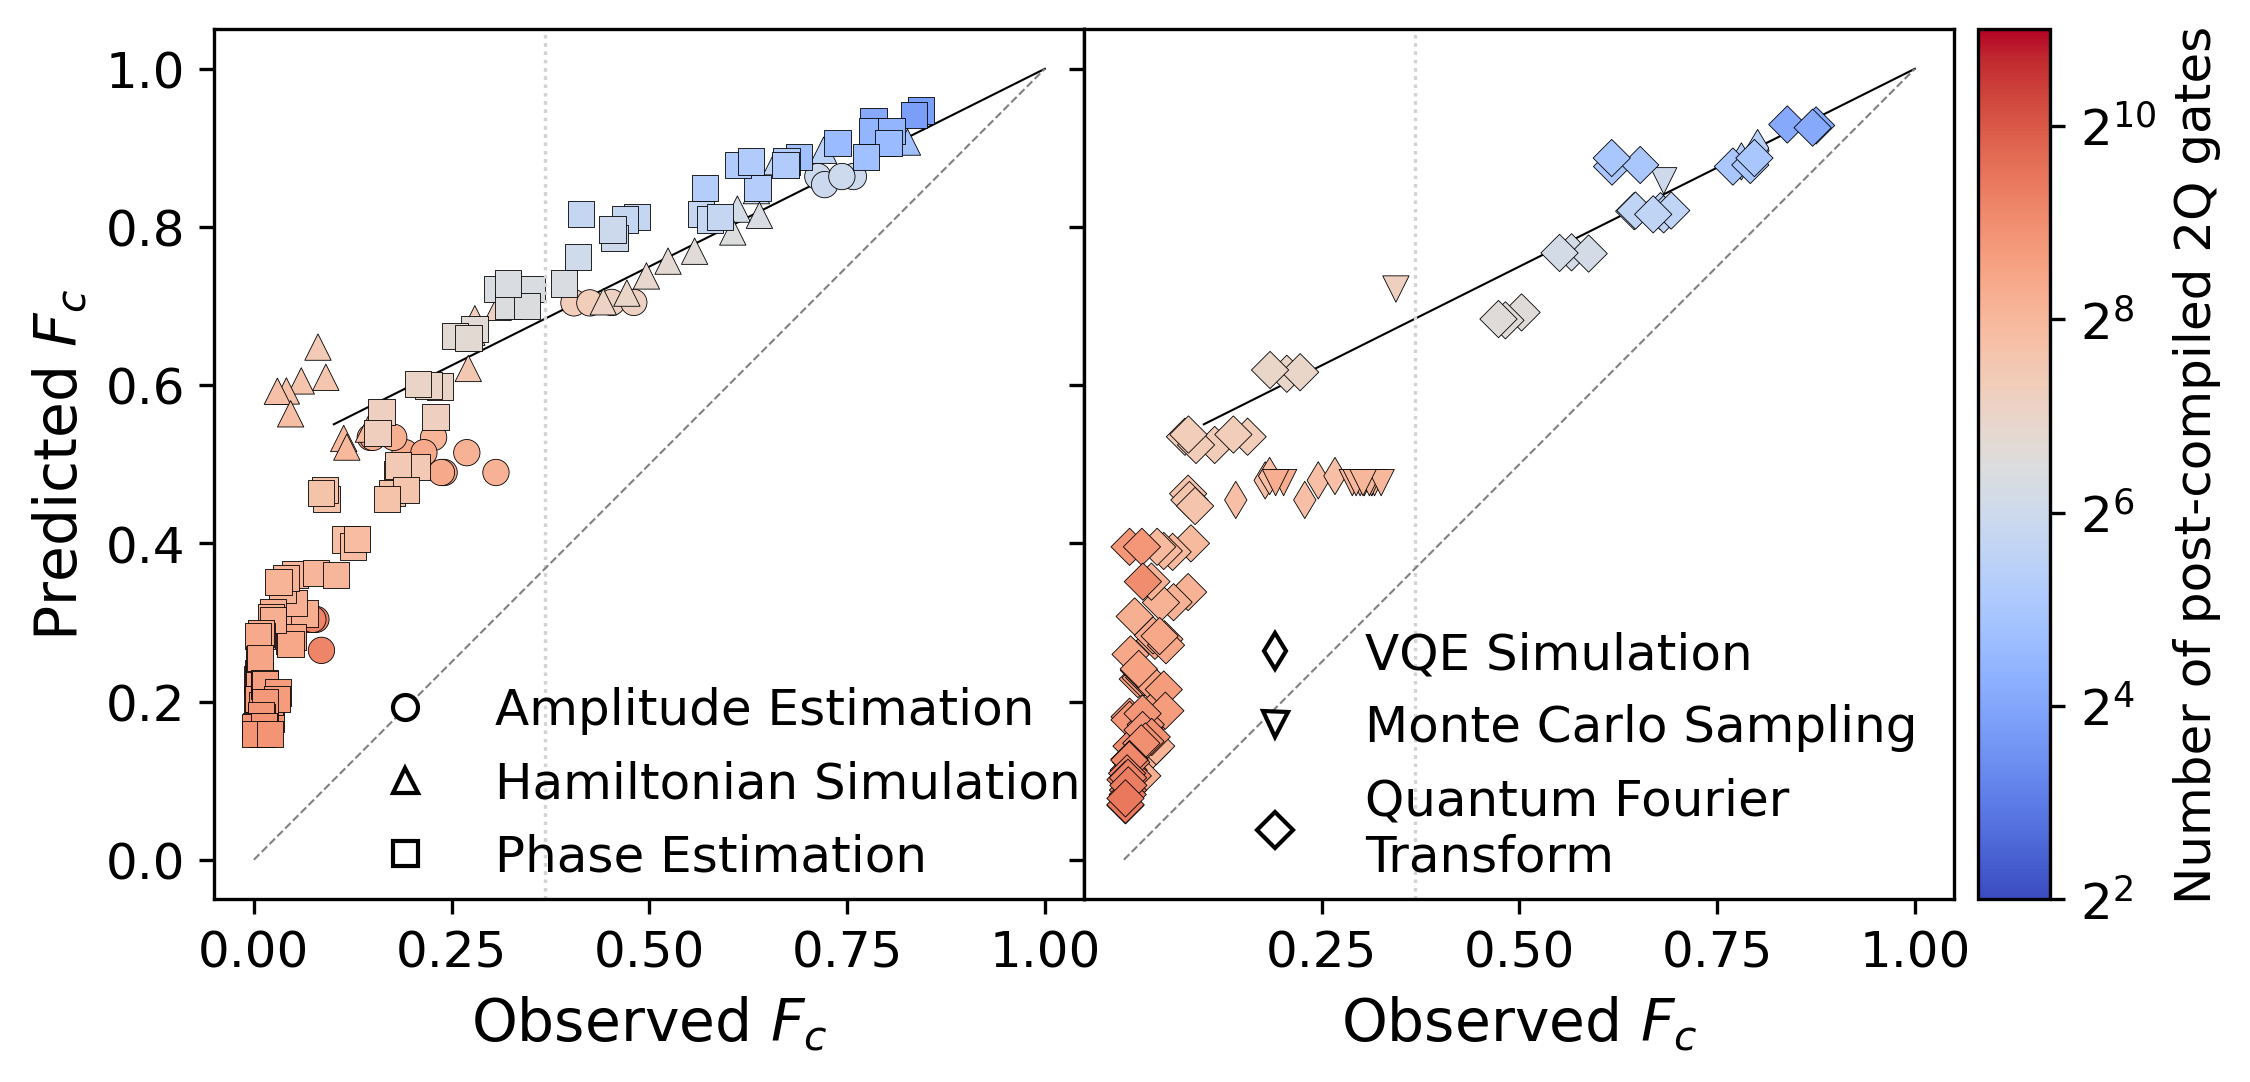

In [8]:
alg_names = {'ae': 'Amplitude Estimation',
             'pe': 'Phase Estimation',
             'hsim': 'Hamiltonian Simulation',
             'vqe': 'VQE Simulation',
             'qft': 'Quantum Fourier\nTransform',
             'mc': 'Monte Carlo Sampling'}

app_abbrevs_and_markers = [
    [
        ("ae", 'o'),
        ("hsim", '^'),
        ("pe", 's'),
    ],
    [
        ("vqe", 'd'),
        ("mc", 'v'),
        ("qft",'D'),
    ]
]
fixed_size = 40 # size of scatter point or False to use circuit width heuristic

inset_opts = [
    dict(xmin=0.88, xmax=1.01, xticks=['0.9', '0.95', '1']),
    dict(xmin=0.95, xmax=1.01, xticks=['0.96', '0.98', '1'])
]

#norm = mpl.colors.Normalize(vmin=cmin, vmax=cmax)
norm = mpl.colors.LogNorm(vmin=cmin, vmax=cmax)

fig = plt.figure(figsize=(8, 4), dpi=300)
gs = fig.add_gridspec(1, 2, hspace=0, wspace=0.0)
axs = gs.subplots(sharex=False, sharey=True)

def make_scatter(app_df, marker):
    app_df = app_df.sort_values('circuit_width', axis=0, ascending=True)
    observed_Fc = app_df['observed_Fc'].to_numpy()
    predicted_Fc = app_df['predicted_Fc'].to_numpy()
    if fixed_size is False:
        sizes = app_df['circuit_width'].to_numpy()**1.5 + 5  # heuristic
    else:
        sizes = fixed_size
    sc = plt.scatter(observed_Fc, predicted_Fc, s=sizes, c=app_df['postcompiled_num_2q_gates'], cmap=cmap,
               label=None, alpha=1, marker=marker, norm=norm, ec='k', linewidths=0.2)

def make_inset(parent_ax, xmin=0.9, xmax=1.0):
    # inset --------------------------------------------------------------------------------------
    ax2 = plt.axes([0,0,1,1])
    ax2.set_axes_locator(InsetPosition(parent_ax, [0.57,0.1,0.4,0.4]))  # [x, y, width, height] of inset in parent plot
    mark_inset(parent_ax, ax2, loc1=2, loc2=4, fc="none", ec='0.5')  # draws "zoom" lines from main plot area to inset

    inset_xs = np.linspace(0, 1.0, 100)  # start is similar to cutoff but tuned so doesn't give extra whitespace
    inset_twosigma = 2 * np.sqrt(inset_xs * (1-inset_xs) / N)
    ax2.plot(inset_xs, inset_xs, label=None, color='gray', ls='--', lw=0.5)
    #ax2.fill_between(inset_xs,y1=inset_xs-inset_twosigma, y2=inset_xs+inset_twosigma, alpha=0.3, color='gray')
    return ax2


## Main plot

# y=x and gray fill
N = 2500  # HARDCODED number of shots per point (25 variants * 100 shots each) - would be better to have included this in dataframe
xs = np.linspace(0, 1, 100)
twosigma = 2 * np.sqrt(xs * (1-xs) / N)

## Scatter plot 
for j in range(2):
    plt.sca(axs[j])
    plt.plot(xs, xs, label=None, color='gray', ls='--', lw=0.5)
    plt.plot(xs[10:], 0.5*xs[10:]+0.5, label=None, color='k', ls='-', lw=0.5, zorder=0)
    #plt.fill_between(xs,y1=xs-twosigma, y2=xs+twosigma, alpha=0.3,color='gray')
    
    # Plot the main plot
    for i, (app_abbrev, marker) in enumerate(app_abbrevs_and_markers[j]):
        app_df = df_fidelities[df_fidelities['circuit_type'] == app_abbrev]
        make_scatter(app_df, marker)
        
    # dummy plot for legend
    for i, (app_abbrev, marker) in enumerate(app_abbrevs_and_markers[j]):
        app_name = alg_names[app_abbrev]
        plt.plot([], [], label=app_name, marker=marker, lw=0, mec='k', mfc='w')
        plt.axvline(1/np.exp(1), color='lightgray', ls=':', lw=0.75, zorder=1)
    plt.legend(loc='lower left', bbox_to_anchor=(0.11, -0.03), frameon=False, fontsize=12, framealpha=0.35)
  
    
    plt.sca(axs[j])
    plt.gca().set_aspect('equal')
    plt.tick_params(axis='both', labelsize=12)
    plt.xlabel("Observed $F_c$", fontsize=14)
    if j==0:
        plt.ylabel("Predicted $F_c$", fontsize=14)
        
axs[0].set_xticks([0.0, 0.25, 0.5, 0.75, 1.0])
axs[1].set_xticks([0.25, 0.5, 0.75, 1.0])
        
# ColorBase is broken with colors.LogNorm
fig.subplots_adjust(right=0.85)
x, y, w, h = axs[0].get_position().bounds
ax_cb = fig.add_axes([.86, y, 0.03, h]);
cb = mpl.colorbar.ColorbarBase(ax_cb, cmap=cmap,
                                norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax),
                                orientation='vertical')
cb.set_label('Number of post-compiled 2Q gates', fontsize=12)
ax_cb.tick_params(labelsize=12)
cbticks = [2,4,6,8,10]
cb.set_ticks([x for x in cbticks])
cb.set_ticklabels(['$2^{%d}$'%x for x in cbticks])
plt.savefig("fig_noem_predicted_vs_observed.pdf", format="pdf", bbox_inches = 'tight')

In [9]:
def average_probs(probs_list, nshots_list):
    shots = collections.defaultdict(lambda: 0)
    totshots = sum(nshots_list)
    for probs, nshots in zip(probs_list, nshots_list):
        for outcome, p in probs.items():
            shots[outcome] += nshots * p
    return {k: v/totshots for k, v in shots.items()}

def histogram_bar_comparison(datarow, title=None, max_selected = 16, filename=None):
    nmarg = nqubits_to_marginalize.get(datarow['circuit_type'], 0)
    circuit_width = datarow['circuit_width']
    ideal_probs = datarow['ideal_probabilities']
    ideal_probs = marginalize(ideal_probs, nmarg, circuit_width)
    
    sim_probs_list = datarow['simulated_variant_probabilities']
    obs_probs_list = datarow['measured_variant_probabilities']
    nshots_list = datarow['variant_num_shots']
    
    obs_probs = average_probs(obs_probs_list, nshots_list)  
    sim_probs = average_probs(sim_probs_list, nshots_list)

    obs_probs = marginalize(obs_probs, nmarg, circuit_width)
    sim_probs = marginalize(sim_probs, nmarg, circuit_width)
    
    fig, ax = plt.subplots(figsize=(3.5,4))
    
    selected_outcomes = []
    for outcome, val in ideal_probs.items():
        if val > 0.1: selected_outcomes.append(outcome)
    max_dist = {}
    for outcome in set(list(sim_probs.keys()) + list(obs_probs.keys())):
        max_dist[outcome] = max(sim_probs.get(outcome, 0), obs_probs.get(outcome, 0))
    sorted_max_items = sorted(list(max_dist.items()), key=lambda x: x[1], reverse=True)
    for outcome, _ in sorted_max_items:        
        if outcome not in selected_outcomes:
            selected_outcomes.append(outcome)
            if len(selected_outcomes) == max_selected:
                break
        
    def selected_prob_vals(probs):
        selected = [probs.get(sel, 0) for sel in selected_outcomes]
        remaining = sum(probs.values()) - sum(selected)
        assert(remaining > -1e-10)
        if remaining < 0: remaining=0
        return np.array(selected + [remaining])
                 
    xs = np.arange(len(selected_outcomes) + 1)  # +1 for final bin
    ideal_ys = selected_prob_vals(ideal_probs)
    
    aq_fidelity = hellinger_fidelity(obs_probs, ideal_probs)
    plt.bar(xs, ideal_ys, width=0.9, label=f'ideal', alpha=0.75)  #  $F_c={aq_fidelity:.2f}$
    
    ys = selected_prob_vals(obs_probs)
    plt.bar(xs, ys, width=0.6, label=f'observed $F_c={aq_fidelity:.2f}$', alpha=0.55, color='k')

    ys = selected_prob_vals(sim_probs)
    aq_fidelity = hellinger_fidelity(sim_probs, ideal_probs)
    plt.bar(xs, ys, width=0.3, label=f'modeled $F_c={aq_fidelity:.2f}$', alpha=0.85)

    ax.set_xticks(xs, list(map(str,selected_outcomes)) + ['rest'], rotation=90, fontsize=11)
    ax.tick_params(axis='y', labelsize=12)
    
    ax.xaxis.set_minor_locator(FixedLocator(xs))
    plt.xlabel("Outcome", fontsize=14)
    plt.ylabel("Probability", fontsize=14)
    if title:
        plt.text(0.55, 0.95, title, ha='center', va='center', transform=ax.transAxes, fontsize=12)
    plt.legend(loc="upper center", bbox_to_anchor=(0.6, 0.92), fontsize=11)
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename, format="pdf", bbox_inches = 'tight')

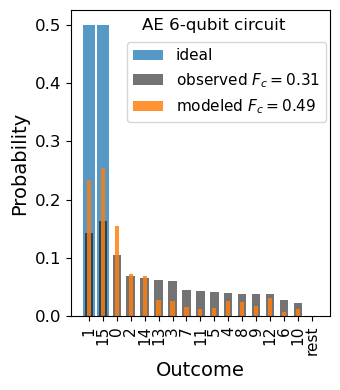

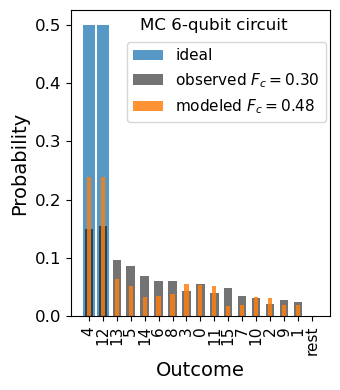

In [10]:
dr = alldata[(alldata['circuit_name'] == 'AEN06V03') & (alldata['repetition'] == 2)].iloc[0]
histogram_bar_comparison(dr, "AE 6-qubit circuit", max_selected = 16, filename="fig_noem_AE6_histcompare.pdf")

dr = alldata[(alldata['circuit_name'] == 'MCN06V01') & (alldata['repetition'] == 2)].iloc[0]
histogram_bar_comparison(dr, "MC 6-qubit circuit", max_selected = 16, filename="fig_noem_MC6_histcompare.pdf")

#### Volumetric pre-error-mitigation plot

In [11]:
def format_number(num):
    if isinstance(num, str): num = float(num)
    num = float('{:.3g}'.format(abs(num)))
    sign = ''
    metric = {'T': 1000000000000, 'B': 1000000000, 'M': 1000000, 'K': 1000, '': 1}
    for index in metric:
        num_check = num / metric[index]
        if num_check >= 1:
            num = round(num_check)
            sign = index
            break
    numstr = f"{str(num)}"
    if '.' in numstr:
        numstr = numstr.rstrip('0').rstrip('.')
    return f"{numstr}{sign}"

def depth_index(d, depth_base):
    if d==0:
        return 0
    else:
        return math.log(d, depth_base) + 1

def bkg_box_at(x, y, value):
    size = 0.6
    return Rectangle((x - size/2, y - size/2), size, size,
             edgecolor = (.75,.75,.75),
             facecolor = (.9,.9,.9),
             fill=True,
             lw=0.5)  

def bkg_empty_box_at(x, y, value):
    size = 0.6
    return Rectangle((x - size/2, y - size/2), size, size,
             edgecolor = (.75,.75,.75),
             facecolor = (1.0,1.0,1.0),
             fill=True,
             lw=0.5)

def polygon_at(x, y, value, numVertices, orientation, color, alpha=0.7, fill=True, size=1.0, label=None):
    #size = 1.0*1
    
    value = min(value, 1.0)
    value = max(value, 0.0)

    fc = color
    ec = (0,0,0) #(0.5,0.5,0.5)
    return RegularPolygon((x, y), numVertices, 
                          orientation=orientation,
                          label=label,
                          radius=size/2,
                          alpha = alpha,
                          edgecolor = ec,
                          facecolor = fc,
                          fill=fill, lw=0.5)

def circle_at(x, y, value, color, alpha=1, fill=True, size=1.0):
    #size = 1.0*1
    
    value = min(value, 1.0)
    value = max(value, 0.0)

    fc = color
    ec = (0.5,0.5,0.5)
    return Circle((x, y), size/2,
             alpha = alpha,
             edgecolor = ec,
             facecolor = fc,
             fill=fill, lw=0.5)

def get_color(value):
    cmap = plt.get_cmap('Spectral')
    value = 0.05 + value*0.9
    return cmap(value)


def aq_box_at(x, y, aq_width, aq_depth, value, depth_base):
    return Rectangle((x - 0.5, y - 0.5), depth_index(aq_depth, depth_base) - 0.5, aq_width,
             edgecolor = (value,value,value),
             facecolor = (value,value,value),
             fill=True,
             lw=1)

def plot_volumetric_background_aq(data, xlabel='Number of 2Q gates', AQ=None,
                                  min_depth_log=0, max_depth_log=22, min_width=0, max_width=None,
                                  plot_width = 6.8, depth_base=2, fontsize=12):
    if max_width is None:
        max_qubits = data['Circuit width'].max()
        max_width = max_qubits + 3
    
    plot_height = 0.5 + plot_width * ((max_width-min_width) / (max_depth_log-min_depth_log))
    
    fig, ax = plt.subplots(figsize=(plot_width, plot_height), constrained_layout=True)
    plt.xlim(min_depth_log, max_depth_log);
    plt.ylim(min_width, max_width);

    xbasis = [x for x in range(min_depth_log,max_depth_log)];
    xround = [depth_base**(x-1) for x in xbasis];
    xticks = [x for x in xbasis if np.isclose(depth_base**(x-1), int(depth_base**(x-1)))];
    xlabels = [format_number(x) for x in xround if np.isclose(x, int(x))] 
    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_xticks(xticks)
    plt.xticks(xticks, xlabels, color='black', rotation=45, ha='right', va='top', rotation_mode="anchor");

    ybasis = [y for y in range(min_width+1,max_width)];
    ax.set_ylabel('Circuit Width', fontsize=fontsize);
    ax.set_yticks(ybasis);

    if AQ is not None:
        AQ_width = AQ
        AQ_depth = AQ*AQ
        ax.add_patch(aq_box_at(1, 1, AQ_width, AQ_depth, 0.87, depth_base))
        maxprod = AQ_depth+1
        #else:
        #    maxprod = max(xround)-1
        
        for w in range(1, max_width-2):
            i_success = 0
            for d in xround:
                if d > maxprod: continue

                id = depth_index(d, depth_base) 
                i_success += 1
                d = xround[i_success]
                id = depth_index(d, depth_base) 
                if (AQ is not None) and (d < AQ**2+1) and (w < AQ+1):
                    ax.add_patch(bkg_box_at(id, w, 0.5))
                else:
                    ax.add_patch(bkg_empty_box_at(id, w, 0.5))

    
    if AQ is not None:
        ax.text(max_depth_log - 2.0, 1.5, "AQ=%d"%AQ, size=12,
            horizontalalignment='right', verticalalignment='center', color=(0.2,0.2,0.2),
            bbox=dict(boxstyle="square,pad=0.3", fc=(.9,.9,.9), ec="grey", lw=1))
    
    ax.set_aspect('equal')
    return fig, ax

class RPHandler(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        center = 0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent
        #import bpdb; bpdb.set_trace()
        p = RegularPolygon(xy=center, numVertices=orig_handle.numvertices,
                           orientation=orig_handle.orientation,
                           radius=12.0/2)
                           #width=width + xdescent,
                           #height=height + ydescent)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]

def plot_volumetric_data(ax, data, xlabel='Number of 2Q gates', ylabel='Circuit width', zlabel='Fidelity', 
                         anno='Algorithm', usePolygon=False, alpha=1, colorfn=get_color):
    x_data, y_data, z_data = data[[xlabel,ylabel,zlabel]].values.T
    x_anno = 0 
    y_anno = 0
    depth_base = 2
    
    # plot data rectangles
    if usePolygon:
        polys = [(3,0,0.9), (3,np.pi,0.9), (3,np.pi/2,0.9), (3,-np.pi/2,0.9), (4,np.pi/4,1.0), (4,0,1.0)]
        
        for i, a in enumerate(pd.unique(data[anno])):
            x_data, y_data, z_data = data[data[anno]==a][[xlabel,ylabel,zlabel]].values.T
            for j in range(len(x_data)):
                x = depth_index(x_data[j], depth_base)
                y = float(y_data[j])
                z = z_data[j]
                ax.add_patch(polygon_at(x, y, z, polys[i][0], polys[i][1],
                                        colorfn(z), fill=True, alpha=0.7, size=polys[i][2]))

        for i, a in enumerate(pd.unique(data[anno])):
            x_data, y_data, z_data = data[data[anno]==a][[xlabel,ylabel,zlabel]].values.T
            for j in range(len(x_data)):
                x = depth_index(x_data[j], depth_base)
                y = float(y_data[j])
                z = z_data[j]
                ax.add_patch(polygon_at(x, y, z, polys[i][0], polys[i][1],
                                        (0,0,0), fill=False, alpha=1.0, size=polys[i][2]))
    else:
        for i in range(len(x_data)):
            x = depth_index(x_data[i], depth_base)
            y = float(y_data[i])
            z = z_data[i]
            ax.add_patch(circle_at(x, y, z, colorfn(z), alpha=alpha, fill=True))

    if usePolygon: # create a legend instead of arrows
        legend_elements = [polygon_at(0, 0, 0, p[0], p[1],
                                    (0,0,0), fill=True, label=anno) 
                           for anno, p in zip(pd.unique(data[anno]),polys)]
        ax.legend(handles=legend_elements, loc='upper right', fontsize=12,
                  handler_map={RegularPolygon: RPHandler()})
        
    else:  # show arrows
        x_annos = []
        y_annos = []
        anno_offsets = {'Amplitude Estimation': [3, 0.7],
                        'Hamiltonian Simulation': [3, 0.3],
                        'Monte Carlo Sampling': [3, 0],
                        'Phase Estimation': [3, 0.7],
                        'Quantum Fourier Transform': [3, 0.7],
                        'VQE Simulation': [3, -2]
                       }
        for a in pd.unique(data[anno]):
            x_anno = depth_index(data[data[anno]==a][xlabel].max(), depth_base)
            y_anno = data[data[anno]==a][ylabel].max()
            offsets = anno_offsets[a]
            if a == 'Quantum Fourier Transform': a='Quantum Fourier\nTransform'
            ax.annotate(a,xy=(x_anno, y_anno),xytext=(x_anno+offsets[0], y_anno+offsets[1]),
                arrowprops=dict(facecolor='black', width=1, headwidth=4, headlength=5, edgecolor=(0.8,0.8,0.8)),
                rotation=0, ha='left', va='top',
                color=(0.2,0.2,0.2), clip_on=True, fontsize=12)
            x_annos.append(x_anno)
            y_annos.append(y_anno)
    return ax

alg_names = {'ae': 'Amplitude Estimation',
             'pe': 'Phase Estimation',
             'hsim': 'Hamiltonian Simulation',
             'vqe': 'VQE Simulation',
             'qft': 'Quantum Fourier Transform',
             'mc': 'Monte Carlo Sampling'}

In [12]:
def plot_binned_volumetric_data(ax, data, xlabel='Number of 2Q gates', ylabel='Circuit width', zlabel='Fidelity',
                                min_depth_log=0, max_depth_log=22, min_width=0, max_width=None,
                                colorfn=get_color):
    x_data, y_data, z_data = data[[xlabel,ylabel,zlabel]].values.T
    x_anno = 0 
    y_anno = 0
    size = 0.8
    
    if max_width is None:
        max_qubits = data['Circuit width'].max()
        max_width = max_qubits + 3
        
    depth_base = np.sqrt(2)

    #Bin data
    xvals = [x for x in range(min_depth_log,max_depth_log)]
    depth_vals = [depth_base**(x-1) for x in xvals]
    width_vals = [y for y in range(min_width,max_width)];
    bin_data = collections.defaultdict(list)
    
    for i in range(len(x_data)):
        di = int(round(depth_index(x_data[i], depth_base)))
        wi = int(y_data[i])
        z = z_data[i]
        bin_data[di, wi].append(z)
        
    for x in xvals:
        for y in width_vals:
            if len(bin_data[x,y]) > 0:
                avg_z = np.mean(bin_data[x,y])
                ax.add_patch(Rectangle((x - 0.5*size, y - 0.5*size), size, size,
                             edgecolor = (0.5,0.5,0.5),
                             facecolor = colorfn(avg_z),
                             fill=True,
                             lw=1))
    return ax


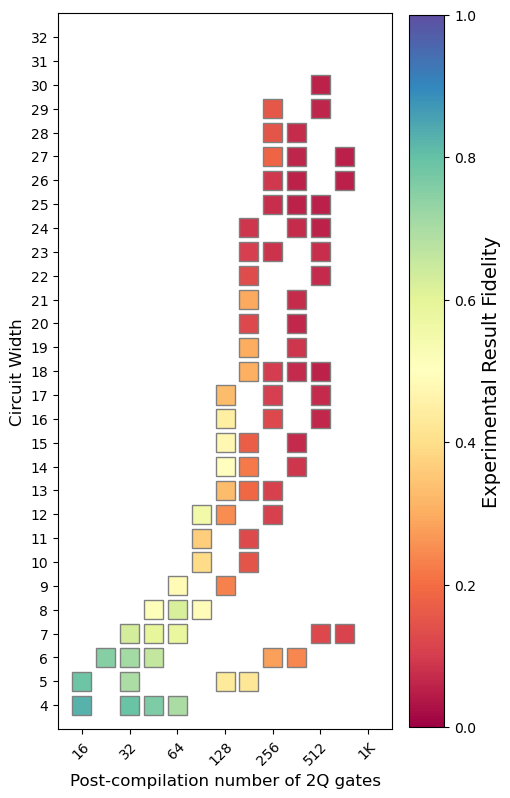

In [13]:
df_AQplotdata = pd.DataFrame({'Algorithm':  df_fidelities.apply(lambda x: alg_names[x['circuit_type']], axis=1),
                              'Post-compilation number of 2Q gates': df_fidelities['postcompiled_num_2q_gates'],
                              'Circuit width': df_fidelities['circuit_width'],
                              'Fidelity': df_fidelities['observed_Fc']})

## generate plot
fig, ax = plot_volumetric_background_aq(df_AQplotdata, xlabel='Post-compilation number of 2Q gates', AQ=None,
                                        min_depth_log=8, max_depth_log=22, min_width=3,
                                        plot_width=5, depth_base=np.sqrt(2))
ax = plot_binned_volumetric_data(ax, df_AQplotdata,
                                 xlabel='Post-compilation number of 2Q gates', zlabel='Fidelity',
                                 min_depth_log=8, max_depth_log=22, min_width=3)

cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=plt.get_cmap('Spectral')), shrink=0.64, panchor=(0.0, 0.5), ax=ax)
#                                         norm=mpl.colors.LogNorm(10**low_pow10, 10**high_pow10)))
cbar.set_label('Experimental Result Fidelity', fontsize=14)

## save to pdf
fig.savefig('fig_AQ_noem_fidelity.pdf', dpi=1000, bbox_inches='tight')

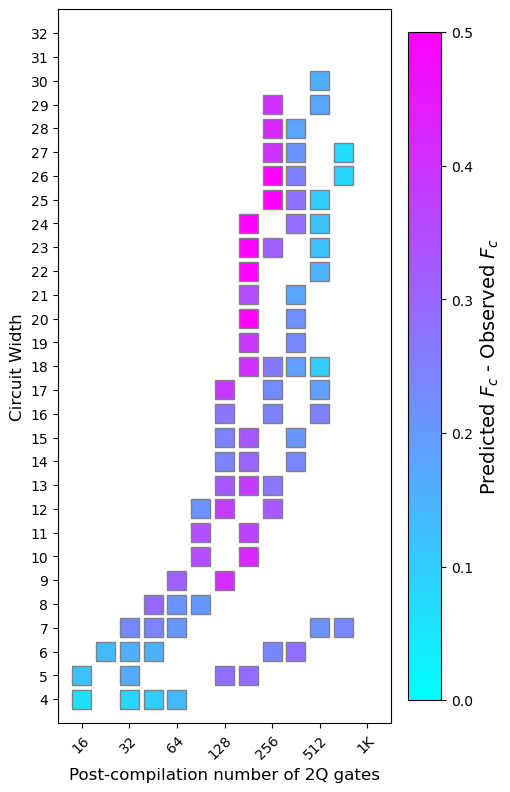

In [14]:
max_color = 0.5
colormap_name = 'cool'
norm = mpl.colors.Normalize(vmin=0, vmax=max_color)
local_cmap = plt.get_cmap(colormap_name)

df_AQplotdata = pd.DataFrame({'Algorithm':  df_fidelities.apply(lambda x: alg_names[x['circuit_type']], axis=1),
                              'Post-compilation number of 2Q gates': df_fidelities['postcompiled_num_2q_gates'],
                              'Circuit width': df_fidelities['circuit_width'],
                              'Fidelity': (df_fidelities['predicted_Fc']-df_fidelities['observed_Fc'])})

## generate plot
fig, ax = plot_volumetric_background_aq(df_AQplotdata, xlabel='Post-compilation number of 2Q gates', AQ=None,
                                        min_depth_log=8, max_depth_log=22, min_width=3,
                                        plot_width=5, depth_base=np.sqrt(2))

ax = plot_binned_volumetric_data(ax, df_AQplotdata,
                                 xlabel='Post-compilation number of 2Q gates', zlabel='Fidelity',
                                 min_depth_log=8, max_depth_log=22, min_width=3,
                                 colorfn=lambda val: local_cmap(norm(val)))

cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=plt.get_cmap(colormap_name), norm=norm),
                    shrink=0.6, panchor=(0.0, 0.5), ax=ax,
                    )
cbar.set_label('Predicted $F_c$ - Observed $F_c$', fontsize=14)
fig.savefig('fig_AQ_noem_fidelity_sim_vs_obs.pdf', dpi=1000, bbox_inches='tight')

## Error mitigated data plots

In [15]:
%%time

from pluralityvote import approximate_plurality_vote
if os.path.exists("../results/derived_em_fidelities.json"):
    df_error_mitigated_fidelities = pd.read_json("../results/derived_em_fidelities.json")
else:
    # Get post-error-mitigation fidelities for each circuit
    #  (takes around 5-10 minutes on a laptop and generates derived_em_fidelities.json)
    rows = []
    for i, (_, row) in enumerate(alldata.iterrows()):
        print(f"Computing {i+1} of {len(alldata)}", end='\r')
        circuit_width = row['circuit_width']
        nmarg = nqubits_to_marginalize.get(row['circuit_type'], 0)
        ideal_probs = row['ideal_probabilities']
        ideal_probs = marginalize(ideal_probs, nmarg, circuit_width)

        nshots_list = row['variant_num_shots']
        mean_shots = int(np.mean(nshots_list))
        obs_probs_list = row['measured_variant_probabilities']
        obs_probs = approximate_plurality_vote(obs_probs_list)
        obs_probs = marginalize(obs_probs, nmarg, circuit_width)

        sim_probs_list = row['simulated_variant_probabilities']
        sim_probs = approximate_plurality_vote(sim_probs_list)
        sim_probs = marginalize(sim_probs, nmarg, circuit_width)

        obs_fidelity = hellinger_fidelity(obs_probs, ideal_probs)
        sim_fidelity = hellinger_fidelity(sim_probs, ideal_probs)

        rows.append({'circuit_type': row['circuit_type'],
                     'repetition': row['repetition'],
                     'circuit_width': row['circuit_width'],
                     'num_2q_gates': row['num_2q_gates'],
                     'observed_em_fidelity': obs_fidelity,
                     'simulated_em_fidelity': sim_fidelity,
                    })
    df_error_mitigated_fidelities = pd.DataFrame(rows)
    df_error_mitigated_fidelities.to_json("../results/derived_em_fidelities_.json")

CPU times: user 3.66 ms, sys: 4.19 ms, total: 7.85 ms
Wall time: 7.57 ms


### AQ plot (EM data volumetric plot)

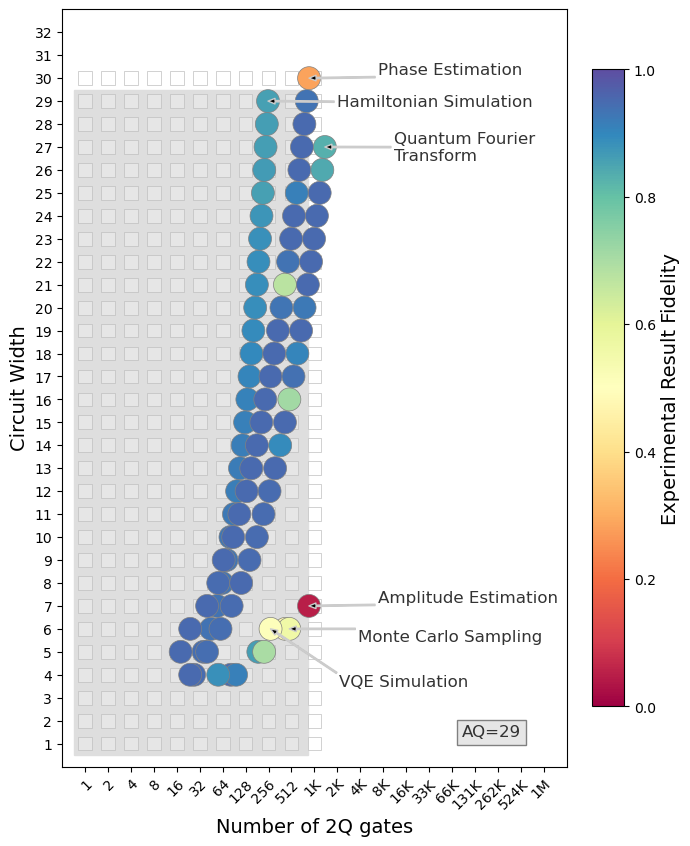

In [16]:
df_AQplotdata = pd.DataFrame({'Algorithm':  df_error_mitigated_fidelities.apply(lambda x: alg_names[x['circuit_type']], axis=1),
                              'Number of 2Q gates': df_error_mitigated_fidelities['num_2q_gates'],
                              'Circuit width': df_error_mitigated_fidelities['circuit_width'],
                              'Fidelity': df_error_mitigated_fidelities['observed_em_fidelity']})

## what we show is the observed min fidelity of each algorithm
dataGroupedMin = df_AQplotdata.groupby(['Algorithm','Circuit width']).min().copy().reset_index()

## generate plot
fig, ax = plot_volumetric_background_aq(dataGroupedMin, AQ=29, fontsize=14)
ax = plot_volumetric_data(ax, dataGroupedMin, zlabel='Fidelity', anno='Algorithm', alpha=1)
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=plt.get_cmap('Spectral')), shrink=0.6, panchor=(0.0, 0.5), ax=ax)
cbar.set_label('Experimental Result Fidelity', fontsize=14)

## save to pdf
fig.savefig('fig_AQ_fidelity.pdf', dpi=1000, bbox_inches='tight')

## Run times for AQ circuits

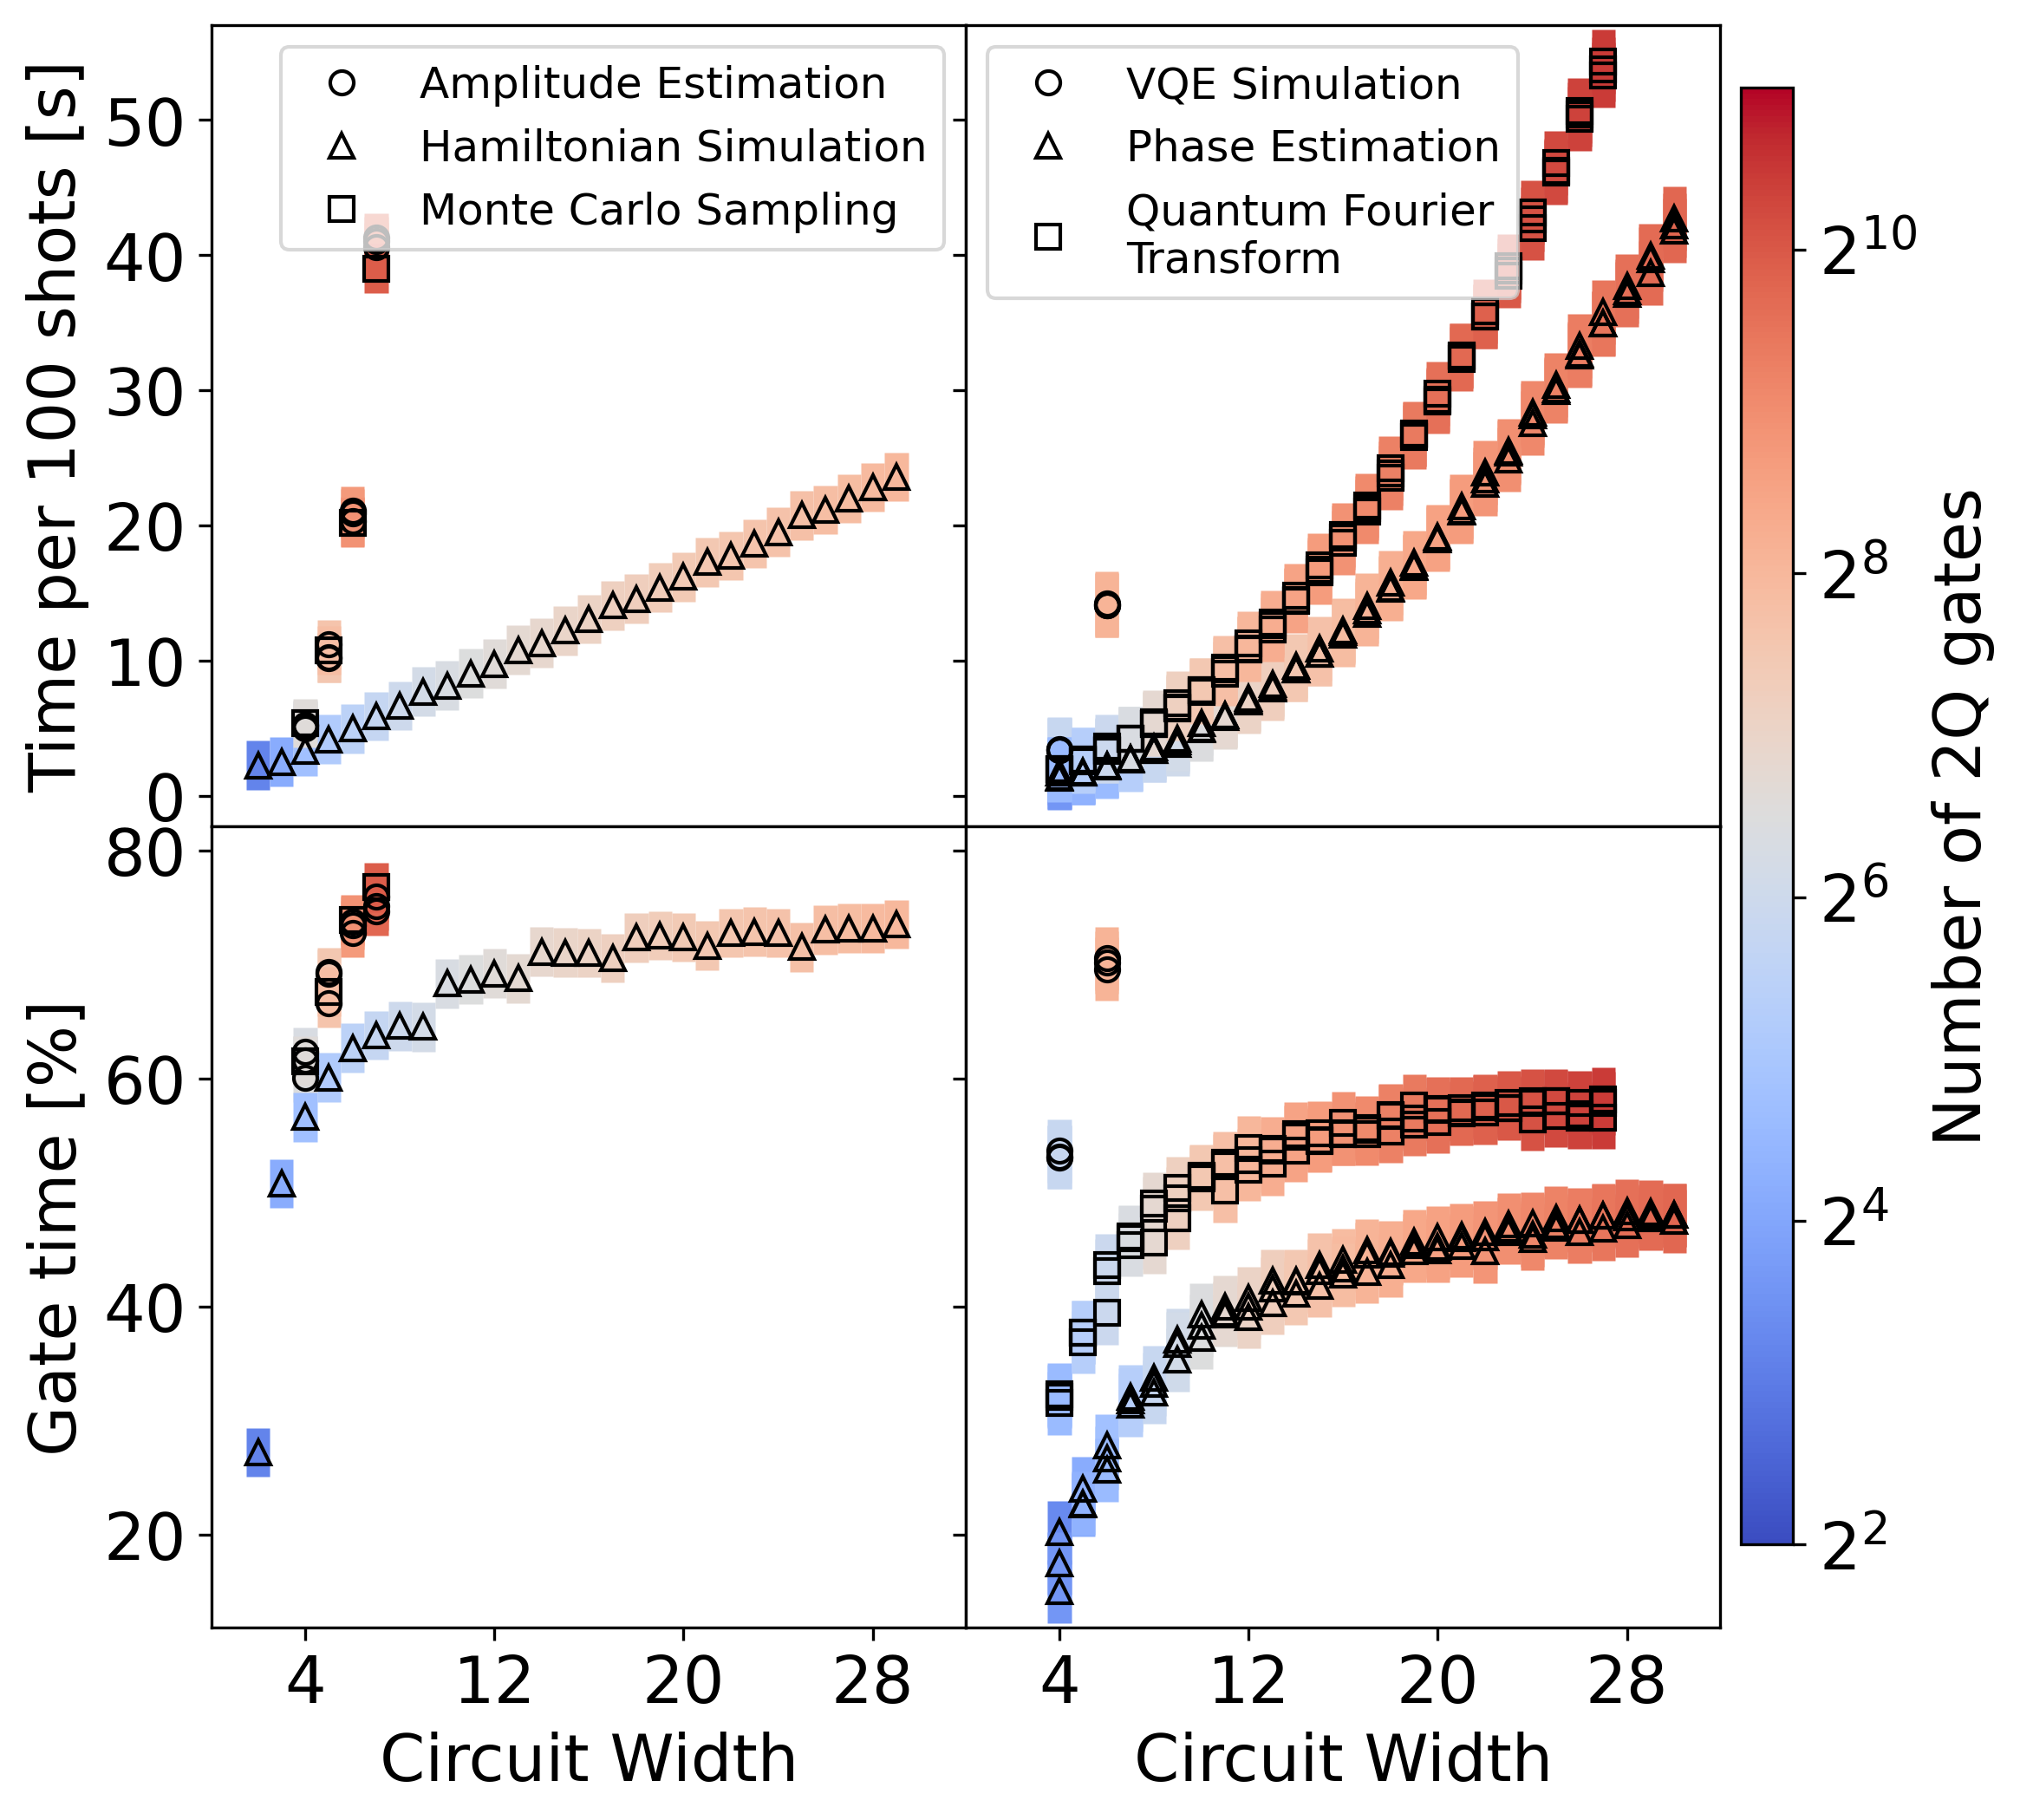

In [17]:
from operator import sub
from scipy.spatial import ConvexHull
from matplotlib.patches import Polygon, Rectangle
from matplotlib.collections import PatchCollection

df = pd.read_csv("../results/data_AQ_run_time.csv")
df['util'] = df['computeRatio'] * 100.0

g1 = ['Amplitude Estimation', 'Hamiltonian Simulation', 'Monte Carlo Sampling (2)']
g2 = ['VQE Simulation (1)', 'Phase Estimation', 'Quantum Fourier Transform (1)']

gb = df.groupby('algorithm')

fig = plt.figure(figsize=(8, 8), dpi=300)
gs = fig.add_gridspec(2, 2, hspace=0, wspace=0)
(ax1, ax2), (ax3, ax4) = gs.subplots(sharex=True, sharey='row')

def scale(value, vmin, vmax):
    return (value - vmin) * 1.0 / (vmax - vmin)

def nearest(x, interval):
    return np.round(x / interval) * interval

def get_aspect(ax):
    figW, figH = ax.get_figure().get_size_inches()
    _, _, w, h = ax.get_position().bounds
    disp_ratio = (figH * h) / (figW * w)  # Ratio of display units
    data_ratio = sub(*ax.get_ylim()) / sub(*ax.get_xlim())  # Ratio of data units (negative over negative because of the order of subtraction)
    return disp_ratio / data_ratio

def one_row(xparam, yparam, zparam, axs, scale_f, xlabel=None, ylabel=None, square_w = 1, legend=True):
    """
    xparam = 'qubits'
    yparam = 'runTime100' | computeRatio'
    zparam = 'n_2q_qiskit'
    """
    for i, alg_group in enumerate([g1, g2]):
        plt.sca(axs[i])
        patches = []
        markers = ['o', '^', 's', 'd']
        for j, aqc in enumerate(alg_group):
            g = gb.get_group(aqc)
            x = g[xparam].values
            y = g[yparam].values
            aqc = aqc.strip(" (1)")
            aqc = aqc.strip(" (2)")
            if aqc == 'Quantum Fourier Transform':
                aqc = 'Quantum Fourier\nTransform'
            plt.plot(x, y, label=aqc, c='k', marker=markers[j], mfc='None', lw=0.0, ms=6.5, alpha=1 )
        
        if legend:
            plt.legend(framealpha=0.75, fontsize=12)

        if square_w is None:
            xrange = sub(*plt.xlim())
            square_w = xrange / 20
        ar = get_aspect(plt.gca()) / 2.5
        for aqc in alg_group:
            g = gb.get_group(aqc)
            u = g[xparam].values
            v = g[yparam].values
            w = g[zparam].values
            for (x,y,z) in zip(u, v, w):
                cu = scale_f(z)
                p = Rectangle([x - 0.5 * square_w, y - 0.5 * square_w / ar], square_w, square_w / ar , fc=cmap(cu), ec='None', lw=0.15, alpha=1)
                patches += [p]

        plt.gca().add_collection(PatchCollection(patches, match_original=True))
        plt.xlabel(xlabel)
        if i == 0:
            plt.ylabel(ylabel)
            
vmin = 2
vmax = 11
scale_f = lambda z: scale((np.log2(z)), vmin=vmin, vmax=vmax)
one_row('qubits', 'runTime100', 'n_2q_qiskit', (ax1, ax2),  scale_f, ylabel='Time per 100 shots [s]', xlabel='Circuit Width', square_w=1)
one_row('qubits', 'util', 'n_2q_qiskit', (ax3, ax4), scale_f, ylabel='Gate time [%]', xlabel='Circuit Width', square_w=1, legend=False)


fs = 18
for ax in (ax1, ax2, ax3, ax4):
    ax.tick_params(labelsize=fs)
    ax.xaxis.label.set_fontsize(fs)
    ax.yaxis.label.set_fontsize(fs)
    
wx = [4, 12, 20, 28]
ax1.xaxis.set_ticks(wx) 
ax2.xaxis.set_ticks(wx) 
    
fig.subplots_adjust(right=0.85)
ax = fig.add_axes([.86, 0.15, 0.025, 0.7]);

norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
cb1.set_label('Number of 2Q gates', fontsize=fs)
ax.tick_params(labelsize=fs)

cbticks = [2,4,6,8,10]
cb1.set_ticks(cbticks)
cb1.set_ticklabels(['$2^{%d}$'%x for x in cbticks])
fig.savefig('fig_aqcircuit_runtimes.pdf')